In [1]:
import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import numpy as np
import pandas as pd
import astropy
from astropy.stats import BoxLeastSquares

import lightkurve as lk
import matplotlib.gridspec as gridspec


def ChauventsCriteron(x, y, z, mean=None, stdv=None):
    from scipy.special import erfc
    if mean is None:
        mean = y.mean()           # Mean of incoming array y
    if stdv is None:
        stdv = y.std()            # Its standard deviation
    N = len(y)                   # Lenght of incoming arrays
    criterion = 1.0/(2*N)        # Chauvenet's criterion
    d = abs(y-mean)/stdv         # Distance of a value to mean in stdv's
    d /= 2.0**0.5                # The left and right tail threshold values
    prob = erfc(d)               # Area normal dist.    
    filter = prob >= criterion   # The 'accept' filter array with booleans
    
    xf = x[filter]; yf = y[filter]; zf=z[filter]
    print ("criterion: ", criterion)
    print ("3*std:", std(y))
#     return filter                # Use boolean array outside this function
    return xf,yf,zf

Nsig=3; bin_size=5; window_size=201

In [2]:
#------------------------------Finding Downloaded TESS Data Files --------------------------------------
# path = '/Users/felizd/Desktop/Felix/TESSdata/' #location of where I put downloaded files
path = '/Users/felizd/Desktop/Felix/TESSdata/Sector01/curves/clean' #location of where I put downloaded files

data = [os.path.join(dirpath, f) # an array of path names to be looped over
    for dirpath, dirnames, files in os.walk(path) #recursively searches through directory
    for f in fnmatch.filter(files, '*.lc')] #finds every file (*) that ends with .lc

print ("number of files: ",len(data)) #number of files)

# for d in range(len(data)):
#     print ("data set #", d+1 ," : ", data[d]) #I added the d+1 because python does zero-indexing (https://en.wikipedia.org/wiki/Zero-based_numbering)
#     print ("")

number of files:  1084


In [3]:
interesting = str(183494855)

for d in range(len(data)):
    if interesting in data[d]:
        print ("file number: ", d, "file name: ", data[d])
        x= data[d] #finding where specific light curve is in our cleaned light curve folder
        
print ("x=", x)        
print ("ra: ", 18.3812, "dec: ", -76.0526) 

file number:  161 file name:  /Users/felizd/Desktop/Felix/TESSdata/Sector01/curves/clean/183494855_sector01_3_3.lc
x= /Users/felizd/Desktop/Felix/TESSdata/Sector01/curves/clean/183494855_sector01_3_3.lc
ra:  18.3812 dec:  -76.0526


Creating our cleaned light curve using Ryan Oelker's pipeline
not using Chauvent's criterion


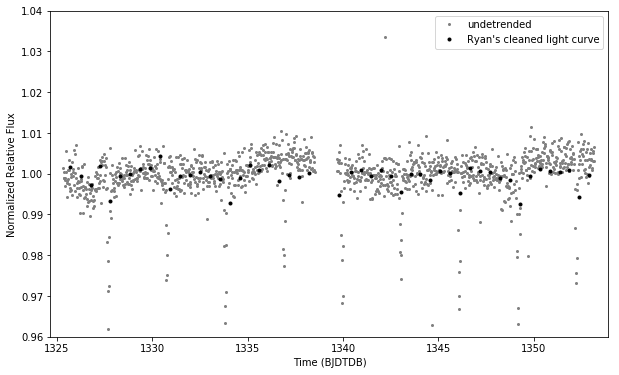

In [25]:
print("Creating our cleaned light curve using Ryan Oelker's pipeline")

Nsig=3; bin_size=5; window_size=201; spacing=0.02


time     = np.transpose(np.loadtxt(x))[0] #first  (zero indexing in python) column 
mag      = np.transpose(np.loadtxt(x))[1] #second (zero indexing in python) column 
magerror = np.transpose(np.loadtxt(x))[2] #third (zero indexing in python) column 

mask = np.where(np.isnan(mag)==False)[0] #creating array of only real numbers by setting np.isnan(mag)==False. 
time = time[mask]                        #Sometimes there are holes in data filled with NaNs
mag = mag[mask]
magerror = magerror[mask]

flux = 10.0**(mag/-2.5)/np.mean(10.0**(mag/-2.5))
fluxerror = flux*(10.0**(magerror/2.5)-1.0)

#removing outliers with Chauvenet's criterion
# print ("using Chauvent's criterion")
# t2,f2,fe2 = ChauventsCriteron(time,flux,fluxerror) #experiment with Chauvent's criterion

print ("not using Chauvent's criterion")
t2,f2,fe2 = time, flux, fluxerror                  #and without Chauvent's criterion


lc = lk.LightCurve(t2,f2,fe2)
detrended_lc = lc.flatten(window_length=window_size).bin(binsize=bin_size)


plt.figure(figsize=(10,6))
plt.plot(time,flux,c='grey',marker='.',markersize=4,linestyle='none',zorder=0,label='undetrended')
plt.plot(detrended_lc.bin(binsize=bin_size).time,detrended_lc.bin(binsize=bin_size).flux,'k.',label="Ryan's cleaned light curve")
# plt.plot()
plt.xlabel("Time (BJDTDB)")
plt.ylabel("Normalized Relative Flux")
plt.legend(loc='best')
plt.xlim(np.min(detrended_lc.bin(binsize=bin_size).time)-1,np.max(detrended_lc.bin(binsize=bin_size).time)+1)
plt.ylim(0.96,1.04)
plt.show()

Creating our cleaned light curve using a custom aperture


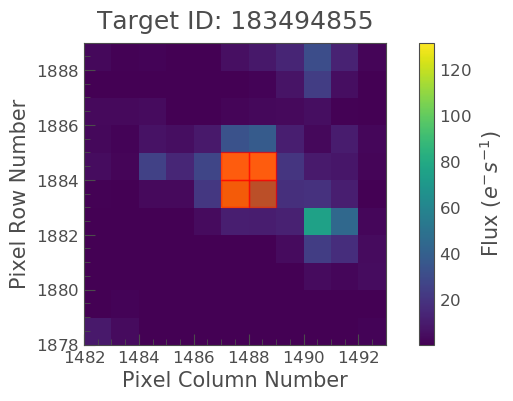

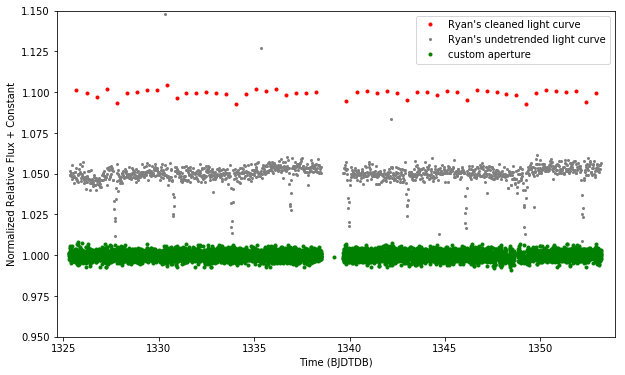

In [37]:
print("Creating our cleaned light curve using a custom aperture")

from lightkurve import search_targetpixelfile

tic = str(183494855)
tpfs = search_targetpixelfile(tic,mission="TESS",).download_all()

tpf.plot(frame=100, aperture_mask=tpf.pipeline_mask, mask_color='red');

Nsig=3; bin_size=5; window_size=201; spacing=0.02
# Build the light curve
pipeline_lc = tpfs[0].to_lightcurve().flatten(window_length=window_size)
for tpf in tpfs:
    pipeline_lc = pipeline_lc.append(tpf.to_lightcurve().flatten(window_length=window_size))

# Clean the light curve
pipeline_lc = pipeline_lc.remove_nans().remove_outliers()

#plot
plt.figure(figsize=(10,6))
plt.plot(detrended_lc.bin(binsize=bin_size).time,detrended_lc.bin(binsize=bin_size).flux+0.1,'r.',label="Ryan's cleaned light curve")
plt.plot(time,flux+0.05,c='grey',marker='.',markersize=4,linestyle='none',label="Ryan's undetrended light curve")
plt.plot(pipeline_lc.bin(binsize=bin_size).time,pipeline_lc.bin(binsize=bin_size).flux,'g.',label='custom aperture')
plt.xlabel("Time (BJDTDB)")
plt.ylabel("Normalized Relative Flux + Constant")
plt.legend(loc='best')
plt.xlim(np.min(detrended_lc.bin(binsize=bin_size).time)-1,np.max(detrended_lc.bin(binsize=bin_size).time)+1)
plt.ylim(0.95,1.15)
plt.show()

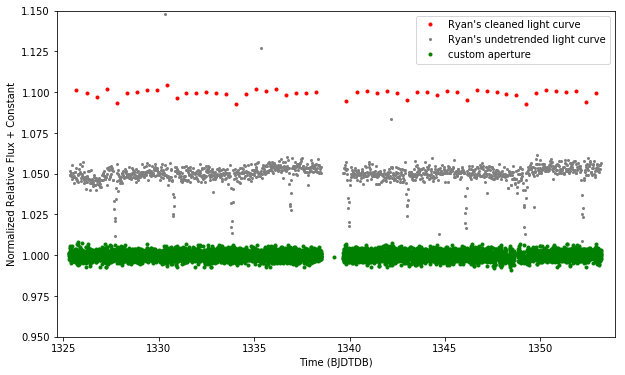

In [36]:
#plot
plt.figure(figsize=(10,6))
plt.plot(detrended_lc.bin(binsize=bin_size).time,detrended_lc.bin(binsize=bin_size).flux+0.1,'r.',label="Ryan's cleaned light curve")
plt.plot(time,flux+0.05,c='grey',marker='.',markersize=4,linestyle='none',label="Ryan's undetrended light curve")
plt.plot(pipeline_lc.bin(binsize=bin_size).time,pipeline_lc.bin(binsize=bin_size).flux,'g.',label='custom aperture')
plt.xlabel("Time (BJDTDB)")
plt.ylabel("Normalized Relative Flux + Constant")
plt.legend(loc='best')
plt.xlim(np.min(detrended_lc.bin(binsize=bin_size).time)-1,np.max(detrended_lc.bin(binsize=bin_size).time)+1)
plt.ylim(0.95,1.15)
plt.show()